## Modèle retenu : Random Forest 
Dans ce notebook, nous rappelons la démarche d'entrainement du modèle avec l'étape de preporcessing , de réglage d'hyperparamètres et d'évaluations. Dans un deuxième lieu, nous implémentons une fonction qui permet de rentrer les fichiers csv train_8 et test et générer le fichier de prédictions (voir partie 2)

## Partie 1

### Preprocessing and feature engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [2]:
# "C:\Users\Helali\Documents\Projet act 208\final_df2.csv"


# Identifier les chemins dans Drive
train_path = 'C:/Users/Sahar Helali/Documents/Projet act 208/train_8.csv' 
val_path = 'C:/Users/Sahar Helali/Documents/Projet act 208/test.csv'   


# De CSV à Pandas Dataframes
train_df = pd.read_csv(train_path,sep=";")
val_df = pd.read_csv(val_path,sep=",")





In [3]:
print("Train DataFrame:")
train_df.head()

Train DataFrame:


,id,genre,age,permisConduire,codeRegion,dejaAssure,ageVehicule,accidentVehicule,primeAnnuelle,canalDistribution,tempsAssure,interesse
0,1,Male,74,1,29,0,1-2 Year,Yes,36008,124,166,0
1,2,Female,44,1,39,0,1-2 Year,Yes,2630,156,124,0
2,3,Female,50,1,39,1,1-2 Year,No,2630,127,80,0
3,4,Female,31,1,28,1,1-2 Year,No,44937,124,120,0
4,5,Male,44,1,50,0,1-2 Year,Yes,35309,8,57,0


In [4]:
print("Validation DataFrame:")
val_df.head()

Validation DataFrame:


,id,genre,age,permisConduire,codeRegion,dejaAssure,ageVehicule,accidentVehicule,primeAnnuelle,canalDistribution,tempsAssure
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217
1,2,Female,60,1,33,0,1-2 Year,Yes,32363,124,102
2,3,Male,30,1,30,0,< 1 Year,Yes,24550,124,45
3,4,Female,26,1,30,1,< 1 Year,No,31136,152,186
4,5,Female,29,1,15,1,< 1 Year,No,32923,152,34


#### Suppression de variables inutiles

In [10]:
# Supprimer la variable ID
train_df.drop(columns=['id'], inplace=True)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   genre              50000 non-null  object
 1   age                50000 non-null  int64 
 2   permisConduire     50000 non-null  int64 
 3   codeRegion         50000 non-null  int64 
 4   dejaAssure         50000 non-null  int64 
 5   ageVehicule        50000 non-null  object
 6   accidentVehicule   50000 non-null  object
 7   primeAnnuelle      50000 non-null  int64 
 8   canalDistribution  50000 non-null  int64 
 9   tempsAssure        50000 non-null  int64 
 10  interesse          50000 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 4.2+ MB


#### Variables manquantes

In [5]:
train_df.isnull().sum()

id                   0
genre                0
age                  0
permisConduire       0
codeRegion           0
dejaAssure           0
ageVehicule          0
accidentVehicule     0
primeAnnuelle        0
canalDistribution    0
tempsAssure          0
interesse            0
dtype: int64

#### Doublons 

In [6]:
# Suppression des doublons dans train_df
num_duplicates = train_df.duplicated().sum()
print(num_duplicates) #4
duplicates =train_df[train_df.duplicated()]
print(duplicates)
train_df = train_df.drop_duplicates()
train_df.duplicated().sum() #0

0
Empty DataFrame
Columns: [id, genre, age, permisConduire, codeRegion, dejaAssure, ageVehicule, accidentVehicule, primeAnnuelle, canalDistribution, tempsAssure, interesse]
Index: []


0

#### Encodage

In [10]:

#Identification des colonnes catégoriques
categorical_columns = ['genre', 'ageVehicule','accidentVehicule','codeRegion','canalDistribution']

# Instanciation du OneHotEncoder
encoder = OneHotEncoder(handle_unknown="ignore",sparse=False, drop='first')  

# Application de l'encodage
encoded = encoder.fit_transform(train_df[categorical_columns])

# Création d'un DataFrame des colonnes encodées
encoded_columns = encoder.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns)

# Combinaison avec les colonnes numériques originales
numeric_columns = train_df.drop(columns=categorical_columns).reset_index(drop=True)
final_df = pd.concat([numeric_columns, encoded_df], axis=1)


In [11]:
final_df.describe()

,id,age,permisConduire,dejaAssure,primeAnnuelle,tempsAssure,interesse,genre_Male,ageVehicule_< 1 Year,ageVehicule_> 2 Years,...,canalDistribution_152,canalDistribution_153,canalDistribution_154,canalDistribution_155,canalDistribution_156,canalDistribution_157,canalDistribution_158,canalDistribution_159,canalDistribution_160,canalDistribution_163
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,25000.500000,42.133400,0.822600,0.303600,1.459320e+05,224.377940,0.24630,0.560500,0.345600,0.053940,...,0.268860,0.001300,0.02248,0.005640,0.038080,0.026700,0.001860,0.000080,0.043220,0.013000
std,14433.901067,17.946005,0.382011,0.459817,6.290689e+05,429.655147,0.43086,0.496331,0.475568,0.225902,...,0.443371,0.036032,0.14824,0.074889,0.191391,0.161207,0.043088,0.008944,0.203354,0.113275
min,1.000000,20.000000,0.000000,0.000000,2.630000e+03,10.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12500.750000,27.000000,1.000000,0.000000,2.382550e+04,85.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25000.500000,40.000000,1.000000,0.000000,3.138450e+04,161.000000,0.00000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37500.250000,51.000000,1.000000,1.000000,3.858350e+04,236.000000,0.00000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50000.000000,140.000000,1.000000,1.000000,4.997200e+06,5960.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Détection des valeurs aberrantes et standardisation des valeurs numériques

In [12]:
train_df[['age','primeAnnuelle','tempsAssure']].describe()


,age,primeAnnuelle,tempsAssure
count,50000.000000,5.000000e+04,50000.000000
mean,42.133400,1.459320e+05,224.377940
std,17.946005,6.290689e+05,429.655147
min,20.000000,2.630000e+03,10.000000
25%,27.000000,2.382550e+04,85.000000
50%,40.000000,3.138450e+04,161.000000
75%,51.000000,3.858350e+04,236.000000
max,140.000000,4.997200e+06,5960.000000


* age (Âge) :

La moyenne d'âge est de 42,13 ans, avec un écart-type de 17,95 ans, indiquant une certaine dispersion autour de la moyenne.
L'âge maximum est de 140 ans, ce qui suggère la présence de valeurs extrêmes ou aberrantes.
Les quartiles montrent que 75 % des assurés ont moins de 51 ans.

* primeAnnuelle (Prime Annuelle) :

La moyenne des primes annuelles est de 145 943,40 €, avec un écart-type de 629 092,80 €, indiquant une grande dispersion des valeurs.
La prime minimale est de 2 630 €, tandis que la prime maximale atteint 4 997 200 €, ce qui suggère la présence de valeurs extrêmes ou aberrantes.
Les quartiles montrent que 25 % des primes sont inférieures à 23 827 €, 50 % inférieures à 31 386 € et 75 % inférieures à 38 585,25 €.

* tempsAssure (Temps Assuré) :

La moyenne du temps assuré est de 224,38 jours (environ 7,5 mois), avec un écart-type de 429,67 jours, indiquant une grande dispersion des valeurs.
Le temps assuré minimum est de 10 jours, tandis que le maximum est de 5 960 jours (environ 16,3 ans), ce qui suggère la présence de valeurs extrêmes ou aberrantes.
Les quartiles montrent que 25 % des individus ont un temps assuré inférieur à 85 jours, 50 % inférieur à 161 jours et 75 % inférieur à 236 jours.

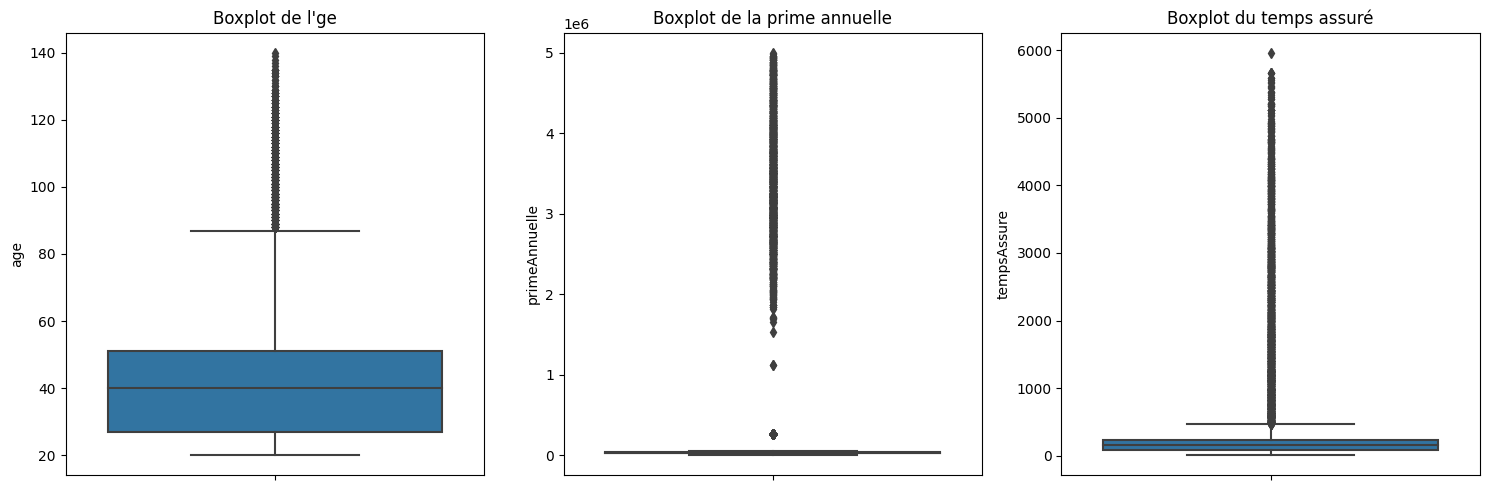

In [13]:
# vérification de présence de outliers pour les variables numériques
# Boxplots

plt.figure(figsize=(15, 5))  # Adjust figure size as needed

# Boxplot pour 'age'
plt.subplot(1, 3, 1)
sns.boxplot(y='age', data=final_df)
plt.title("Boxplot de l'ge")

# Boxplot pour 'primeAnnuelle'
plt.subplot(1, 3, 2)
sns.boxplot(y='primeAnnuelle', data=final_df)
plt.title('Boxplot de la prime annuelle')

# Boxplot pour 'tempsAssure'
plt.subplot(1, 3, 3)
sns.boxplot(y='tempsAssure', data=final_df)
plt.title('Boxplot du temps assuré')


plt.tight_layout()
plt.show()

In [14]:
import pandas as pd

# Calcul de la skewness et de la kurtosis pour chaque variable
skewness = final_df[['age', 'primeAnnuelle', 'tempsAssure']].skew()
kurtosis = final_df[['age', 'primeAnnuelle', 'tempsAssure']].kurt()

# Combinaison des résultats dans un DataFrame
skew_kurt_df = pd.DataFrame({
    'Skewness': skewness,
    'Kurtosis': kurtosis
})

print(skew_kurt_df)


               Skewness   Kurtosis
age            1.275967   2.339969
primeAnnuelle  5.462747  29.204765
tempsAssure    7.029295  57.277308


* Ces résultats suggèrent que les variables primeAnnuelle et tempsAssure présentent des distributions fortement asymétriques avec des queues lourdes, ce qui peut indiquer la présence de valeurs aberrantes ou de segments de clients avec des caractéristiques très différentes.

In [15]:
# Créer une instance de RobustScaler
scaler = RobustScaler()
df_scaled = final_df

# Sélectionner les colonnes à mettre à l'échelle
columns_to_scale = ['age', 'primeAnnuelle', 'tempsAssure']

# Appliquer la mise à l'échelle aux colonnes sélectionnées
df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])

# Afficher le résumé statistique des variables numériques après la mise à l'échelle
print("\nStatistiques descriptives - Variables numériques après RobustScaler:")
df_scaled.describe()


Statistiques descriptives - Variables numériques après RobustScaler:


,id,age,permisConduire,dejaAssure,primeAnnuelle,tempsAssure,interesse,genre_Male,ageVehicule_< 1 Year,ageVehicule_> 2 Years,...,canalDistribution_152,canalDistribution_153,canalDistribution_154,canalDistribution_155,canalDistribution_156,canalDistribution_157,canalDistribution_158,canalDistribution_159,canalDistribution_160,canalDistribution_163
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,25000.500000,0.088892,0.822600,0.303600,7.761720,0.419721,0.24630,0.560500,0.345600,0.053940,...,0.268860,0.001300,0.02248,0.005640,0.038080,0.026700,0.001860,0.000080,0.043220,0.013000
std,14433.901067,0.747750,0.382011,0.459817,42.625620,2.845398,0.43086,0.496331,0.475568,0.225902,...,0.443371,0.036032,0.14824,0.074889,0.191391,0.161207,0.043088,0.008944,0.203354,0.113275
min,1.000000,-0.833333,0.000000,0.000000,-1.948401,-1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12500.750000,-0.541667,1.000000,0.000000,-0.512197,-0.503311,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25000.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37500.250000,0.458333,1.000000,1.000000,0.487803,0.496689,0.00000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50000.000000,4.166667,1.000000,1.000000,336.482958,38.403974,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
### Scaling ( 2eme methode)

In [16]:
corr_matrix = df_scaled.corr() 

In [36]:
import numpy as np

# Set the correlation threshold
threshold = 0.7

# Find pairs of highly correlated variables
highly_correlated_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            highly_correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

print("Highly Correlated Variable Pairs:")
for pair in highly_correlated_pairs:
    print(pair)


Highly Correlated Variable Pairs:
('accidentVehicule_Yes', 'dejaAssure')
('canalDistribution_152', 'ageVehicule_< 1 Year')


In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X = df_scaled[['age', 'primeAnnuelle', 'tempsAssure']]
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif)

         Feature       VIF
0            age  1.000074
1  primeAnnuelle  1.000008
2    tempsAssure  1.000082


#### Pipeline : Encodage & Standardisation appliqué sur le dataframe d'entrainement et de validation

In [19]:

id_validation = val_df['id']  # Conserver la colonne ID dans la validation

# Identification des colonnes catégoriques et numériques
categorical_columns = ['genre', 'ageVehicule', 'accidentVehicule', 'codeRegion', 'canalDistribution']
columns_to_scale = ['age', 'primeAnnuelle', 'tempsAssure']



# Encodage des colonnes catégoriques
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False, drop='first')
encoded_train = encoder.fit_transform(train_df[categorical_columns])
encoded_val = encoder.transform(val_df[categorical_columns])

# Conversion des colonnes encodées en DataFrame
encoded_columns = encoder.get_feature_names_out(categorical_columns)
encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_columns)
encoded_val_df = pd.DataFrame(encoded_val, columns=encoded_columns)

# Mise à l'échelle des colonnes numériques
scaler = RobustScaler()
scaled_train = scaler.fit_transform(train_df[columns_to_scale])
scaled_val = scaler.transform(val_df[columns_to_scale])

scaled_train_df = pd.DataFrame(scaled_train, columns=columns_to_scale)
scaled_val_df = pd.DataFrame(scaled_val, columns=columns_to_scale)

# Combinaison des colonnes encodées et mises à l'échelle avec le reste
final_df = pd.concat(
    [train_df.reset_index(drop=True).drop(columns=categorical_columns + columns_to_scale),
     scaled_train_df.reset_index(drop=True),
     encoded_train_df.reset_index(drop=True)],
    axis=1
)

final_val_df = pd.concat(
    [val_df.reset_index(drop=True).drop(columns=categorical_columns + columns_to_scale),
     scaled_val_df.reset_index(drop=True),
     encoded_val_df.reset_index(drop=True)],
    axis=1
)






C:\Users\Sahar Helali\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [20]:
# Résultat final
print("Final Training DataFrame:")

final_df.head()

Final Training DataFrame:


,id,permisConduire,dejaAssure,interesse,age,primeAnnuelle,tempsAssure,genre_Male,ageVehicule_< 1 Year,ageVehicule_> 2 Years,...,canalDistribution_152,canalDistribution_153,canalDistribution_154,canalDistribution_155,canalDistribution_156,canalDistribution_157,canalDistribution_158,canalDistribution_159,canalDistribution_160,canalDistribution_163
0,1,1,0,0,1.416667,0.313288,0.033113,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0,0,0.166667,-1.948401,-0.245033,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,1,1,0,0.416667,-1.948401,-0.536424,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,1,0,-0.375000,0.918315,-0.271523,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0,0,0.166667,0.265924,-0.688742,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
print("\nFinal Validation DataFrame:")
final_val_df.head()




Final Validation DataFrame:


,id,permisConduire,dejaAssure,age,primeAnnuelle,tempsAssure,genre_Male,ageVehicule_< 1 Year,ageVehicule_> 2 Years,accidentVehicule_Yes,...,canalDistribution_152,canalDistribution_153,canalDistribution_154,canalDistribution_155,canalDistribution_156,canalDistribution_157,canalDistribution_158,canalDistribution_159,canalDistribution_160,canalDistribution_163
0,1,1,0,0.166667,0.614548,0.370861,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0,0.833333,0.066303,-0.390728,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,0,-0.416667,-0.463105,-0.768212,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,1,-0.583333,-0.016838,0.165563,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,1,-0.458333,0.104249,-0.841060,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Rééquilibrage de la base de données SMOTE

In [22]:


import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


# Définition de X et y
X = final_df.drop(columns=['interesse'])
y = final_df['interesse']

# Vérification de la distribution de y
print('------------Avant SMOTE')
print(y.value_counts())

# La classe 0 est 3 fois plus représenté que la classe 1
# application de smote



smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


print('------------Après SMOTE')
print(y_resampled.value_counts())



------------Avant SMOTE
0    37685
1    12315
Name: interesse, dtype: int64
------------Après SMOTE
0    37685
1    37685
Name: interesse, dtype: int64


### Modélisation

In [23]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


#### RANDOM FOREST 

In [24]:

# Random Forest Model

best_params = {'n_estimators': 200,
               'max_depth': None,
               'min_samples_split': 5,
               'min_samples_leaf': 1
              }

rf_model = RandomForestClassifier(**best_params,random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)




#### Evaluation du premier modèle de Random Forest

In [25]:

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      7591
           1       0.86      0.88      0.87      7483

    accuracy                           0.87     15074
   macro avg       0.87      0.87      0.87     15074
weighted avg       0.87      0.87      0.87     15074



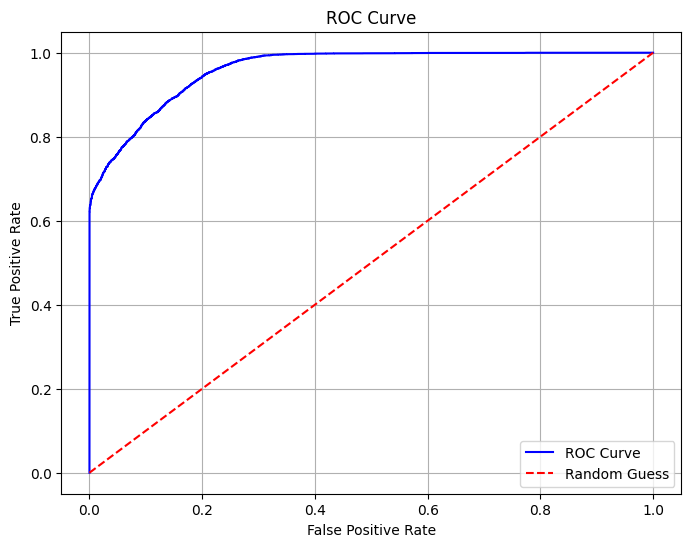

In [26]:
y_scores = rf_model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])
# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [27]:

# Calcul de l'AUC
auc = roc_auc_score(y_test, y_scores[:, 1])
print(f"AUC : {auc:.2f}")


AUC : 0.96


## Partie 2

### Prédictions 

In [30]:
def generate_predictions(train_path, val_path, output_csv_path):
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import OneHotEncoder, RobustScaler
    from sklearn.ensemble import RandomForestClassifier

    # importation de données 
    train_df = pd.read_csv(train_path, sep=";")
    val_df = pd.read_csv(val_path, sep=",")
    id_validation = val_df['id']  # Keep the ID column

    # Encodage et standardisation
    categorical_columns = ['genre', 'ageVehicule', 'accidentVehicule', 'codeRegion', 'canalDistribution']
    columns_to_scale = ['age', 'primeAnnuelle', 'tempsAssure']

    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False, drop='first')
    encoded_train = encoder.fit_transform(train_df[categorical_columns])
    encoded_val = encoder.transform(val_df[categorical_columns])

    scaler = RobustScaler()
    scaled_train = scaler.fit_transform(train_df[columns_to_scale])
    scaled_val = scaler.transform(val_df[columns_to_scale])

    # Combinee les colonnes
    encoded_columns = encoder.get_feature_names_out(categorical_columns)
    encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_columns)
    encoded_val_df = pd.DataFrame(encoded_val, columns=encoded_columns)
    scaled_train_df = pd.DataFrame(scaled_train, columns=columns_to_scale)
    scaled_val_df = pd.DataFrame(scaled_val, columns=columns_to_scale)

    final_df = pd.concat(
        [train_df.reset_index(drop=True).drop(columns=categorical_columns + columns_to_scale + ['id', 'interesse']),
         scaled_train_df.reset_index(drop=True),
         encoded_train_df.reset_index(drop=True)], axis=1
    )

    final_val_df = pd.concat(
        [val_df.reset_index(drop=True).drop(columns=categorical_columns + columns_to_scale + ['id']),
         scaled_val_df.reset_index(drop=True),
         encoded_val_df.reset_index(drop=True)], axis=1
    )

    # Vérification des variables sur les deux datasets
    missing_cols = set(final_df.columns) - set(final_val_df.columns)
    for col in missing_cols:
        final_val_df[col] = 0 
        
    # Réorganisation des colonnes de validation pour s'aligner avec les colonnes d'apprentissage
    final_val_df = final_val_df[final_df.columns]

    # Modélisation 
    X_train = final_df
    y_train = train_df['interesse']  # Target column
    X_val = final_val_df

    best_params = {
        'n_estimators': 200,
        'max_depth': None,
        'min_samples_split': 5,
        'min_samples_leaf': 1
    }

    model = RandomForestClassifier(**best_params, random_state=42)
    model.fit(X_train, y_train)

    # Prédictions
    val_probabilities = model.predict_proba(X_val)[:, 1]
    val_predictions = (val_probabilities >= 0.5).astype(int)

    # Résultats 
    output_df = pd.DataFrame({
        'id': id_validation,
        'probability': val_probabilities,
        'interesse': val_predictions
    })

    output_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")




In [31]:

generate_predictions(
    train_path='C:/Users/Sahar Helali/Documents/Projet act 208/train_8.csv',
    val_path='C:/Users/Sahar Helali/Documents/Projet act 208/test.csv',
    output_csv_path='C:/Users/Sahar Helali/Documents/Projet act 208/prediction_8.csv'
)

C:\Users\Sahar Helali\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Predictions saved to C:/Users/Sahar Helali/Documents/Projet act 208/prediction_8.csv


In [32]:
predictions = pd.read_csv("C:/Users/Sahar Helali/Documents/Projet act 208/prediction_8.csv")
predictions.head()

,id,probability,interesse
0,1,0.866100,1
1,2,0.427476,0
2,3,0.655454,1
3,4,0.000000,0
4,5,0.002667,0
